In [1]:
#!conda install -c conda-forge xgboost -y
#!conda install -c anaconda gensim -y
#!conda install -c conda-forge wordcloud -y

In [44]:
#%pylab inline
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from pprint import pprint
from xgboost import XGBClassifier
from gensim.models import Phrases, LdaModel
from gensim.corpora import Dictionary
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import brown
from nltk import FreqDist
from wordcloud import WordCloud 
from collections import OrderedDict
from matplotlib import pyplot as plt

# Criando um Data Frame com 5 colunas: diretorio, categoria, nome_arq, titulo, texto

In [45]:
path = 'data/arquivos_bbc/bbc/'

In [46]:
categories = []
titles = []
all_data = []
#df = pd.DataFrame()
# dirname
for dirname, categoryname, filenames in os.walk(path):
    # filename
    for filename in filenames:
        if filename == 'README.TXT':
            filenames.remove(filename)
        else:
            # Absolute path
            current_file = os.path.abspath(os.path.join(dirname, filename))
            open_file = open(current_file, 'r', encoding="latin-1")
            # text_data
            text_data = open_file.read().split('\n')
            text_data = list(filter(None, text_data))
            titles.append(text_data[0])
            all_data.append((dirname, dirname.rsplit('/',1)[1], filename, text_data[0], text_data[1:]))
            #data_df = f"Directory: {dirname}, Category: {dirname.rsplit('/',1)[1]}, FileName: {filename}, Title: {text_data[0]}, Text: {text_data[1:]}"
            #print(data_df)
df = pd.DataFrame(all_data, columns=['directory', 'category', 'fileName', 'title', 'text'])
df['text'] = df.text.astype(str)
print(df.head()) 

                        directory  category fileName  \
0  data/arquivos_bbc/bbc/business  business  001.txt   
1  data/arquivos_bbc/bbc/business  business  002.txt   
2  data/arquivos_bbc/bbc/business  business  003.txt   
3  data/arquivos_bbc/bbc/business  business  004.txt   
4  data/arquivos_bbc/bbc/business  business  005.txt   

                               title  \
0  Ad sales boost Time Warner profit   
1   Dollar gains on Greenspan speech   
2  Yukos unit buyer faces loan claim   
3  High fuel prices hit BA's profits   
4  Pernod takeover talk lifts Domecq   

                                                text  
0  ['Quarterly profits at US media giant TimeWarn...  
1  ['The dollar has hit its highest level against...  
2  ['The owners of embattled Russian oil giant Yu...  
3  ['British Airways has blamed high fuel prices ...  
4  ["Shares in UK drinks and food firm Allied Dom...  


In [47]:
df.describe()

directory category fileName  \
count                          2225     2225     2225   
unique                            5        5      511   
top     data/arquivos_bbc/bbc/sport    sport  001.txt   
freq                            511      511        5   

                                   title  \
count                               2225   
unique                              2096   
top     Microsoft seeking spyware trojan   
freq                                   2   

                                                     text  
count                                                2225  
unique                                               2092  
top     ['Microsoft has warned PC users to update thei...  
freq                                                    2

In [48]:
df.category.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

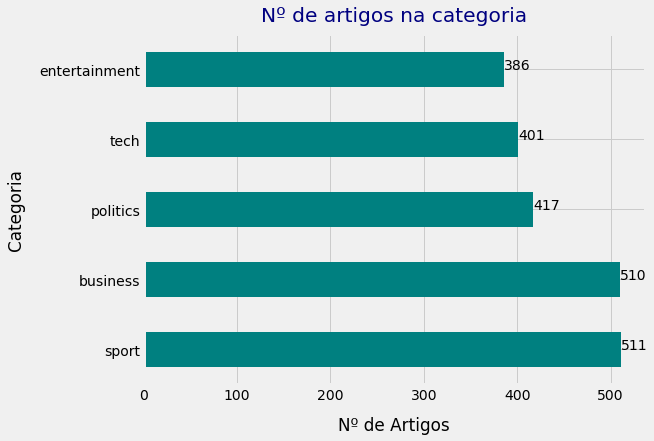

In [50]:
bar_plot=df.category.value_counts().plot(kind='barh', figsize=(8, 6), color='teal')
plt.xlabel("Nº de Artigos", labelpad=14)
plt.ylabel("Categoria", labelpad=14)
plt.title("Nº de artigos na categoria", y=1.02, color='navy')

for index, value in enumerate(df.category.value_counts()):
    plt.text(value, index, str(value))
    
plt.savefig('num_artigos_categoria.png')

## Label Encoder

In [8]:
# 0 - business, 1 -entertainment, 2 - politics, 3 - sport, 4 - tech
label_enc = LabelEncoder()
df['label'] = label_enc.fit_transform(df['category'])
df.head()

directory  category fileName  \
0  data/arquivos_bbc/bbc/business  business  001.txt   
1  data/arquivos_bbc/bbc/business  business  002.txt   
2  data/arquivos_bbc/bbc/business  business  003.txt   
3  data/arquivos_bbc/bbc/business  business  004.txt   
4  data/arquivos_bbc/bbc/business  business  005.txt   

                               title  \
0  Ad sales boost Time Warner profit   
1   Dollar gains on Greenspan speech   
2  Yukos unit buyer faces loan claim   
3  High fuel prices hit BA's profits   
4  Pernod takeover talk lifts Domecq   

                                                text  label  
0  ['Quarterly profits at US media giant TimeWarn...      0  
1  ['The dollar has hit its highest level against...      0  
2  ['The owners of embattled Russian oil giant Yu...      0  
3  ['British Airways has blamed high fuel prices ...      0  
4  ["Shares in UK drinks and food firm Allied Dom...      0

In [9]:
# Um conjunto de palavras
df_txt = np.array(df['text'])

In [10]:
df_txt

array(['[\'Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.\', \'The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.\', "Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL\'s underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL\'s existing cu

## Pré-processe e vetorização do texto

In [11]:
stopwords = nltk.corpus.stopwords.words('english')

def docs_preprocessor(docs):
    # recuperando apenas letras
    tokenizer = RegexpTokenizer('[A-Za-z]\w+')
    
    for idx in range(len(docs)):
         # converte para minusculo
        docs[idx] = docs[idx].lower() 
        # Dividido em palavras
        docs[idx] = tokenizer.tokenize(docs[idx])  
    
    # Lematizar todas as palavras com len>2 em documentos
    lemmatizer = WordNetLemmatizer()
    docs = [[nltk.stem.WordNetLemmatizer().lemmatize(token) for token in doc if len(token) > 2 and token not in stopwords] for doc in docs]
         
    return docs

In [12]:
df_txt = docs_preprocessor(df_txt)

* <b>bigrama</b>
<p>Um bigrama ou digrama é uma sequência de dois elementos adjacentes de uma sequência de tokens, que normalmente são letras, sílabas ou palavras.</p>
<br>
* <b>trigram</b>
<p>Sigla constituída de três caracteres reunidos..</p>

In [13]:
# Adicione bigramas e trigramas a documentos (somente aqueles que aparecem 10 vezes ou mais)
bigram = Phrases(df_txt, min_count=10)
trigram = Phrases(bigram[df_txt])

for idx in range(len(df_txt)):
    for token in bigram[df_txt[idx]]:
        if '_' in token:
            df_txt[idx].append(token)
    for token in trigram[df_txt[idx]]:
        if '_' in token:
            df_txt[idx].append(token)

## Removendo palavras raras:

In [14]:
# Cria uma representação de dicionário dos documentos
dictionary = Dictionary(df_txt)
print('Nº de palavras únicas em documentos iniciais:', len(dictionary))

# Filtra palavras que ocorrem em menos de 10 documentos ou em mais de 20% dos documentos
dictionary.filter_extremes(no_below=10, no_above=0.2)
print('Nº de palavras únicas depois de remover palavras raras e comuns:', len(dictionary))

Nº de palavras únicas em documentos iniciais: 27291
Nº de palavras únicas depois de remover palavras raras e comuns: 5809


In [15]:
df['text2'] = df_txt

In [16]:
df['text3'] = [' '.join(map(str, j)) for j in df['text2']]

In [17]:
df.iloc[1475:1480,:]

directory category fileName  \
1475  data/arquivos_bbc/bbc/sport    sport  163.txt   
1476  data/arquivos_bbc/bbc/sport    sport  164.txt   
1477  data/arquivos_bbc/bbc/sport    sport  165.txt   
1478  data/arquivos_bbc/bbc/sport    sport  166.txt   
1479  data/arquivos_bbc/bbc/sport    sport  167.txt   

                                  title  \
1475       Arsenal through on penalties   
1476   Ajax refuse to rule out Jol move   
1477   Unclear future for striker Baros   
1478  Prutton poised for lengthy FA ban   
1479  Robben plays down European return   

                                                   text  label  \
1475  ['Arsenal win 4-2 on penalties', 'The Spanish ...      3   
1476  ["Ajax have refused to reveal whether Tottenha...      3   
1477  ["Liverpool forward Milan Baros is uncertain w...      3   
1478  ["Southampton's David Prutton faces a possible...      3   
1479  ['Injured Chelsea winger Arjen Robben has insi...      3   

                                                  text2  \
1475  [arsenal, win, penalty, spanish, goalkeeper, s...   
1476  [ajax, refused, reveal, whether, tottenham, bo...   
1477  [liverpool, forward, milan, baros, uncertain, ...   
1478  [southampton, david, prutton, face, possible, ...   
1479  [injured, chelsea, winger, arjen, robben, insi...   

                                                  text3  
1475  arsenal win penalty spanish goalkeeper saved a...  
1476  ajax refused reveal whether tottenham bos mart...  
1477  liverpool forward milan baros uncertain whethe...  
1478  southampton david prutton face possible seven ...  
1479  injured chelsea winger arjen robben insisted c...

### Vetores de palavras

In [18]:
vectorizer = TfidfVectorizer(input='content', analyzer = 'word', lowercase=True, stop_words='english',\
                                   ngram_range=(1, 3), min_df=40, max_df=0.20,\
                                  norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=True)
text_vector = vectorizer.fit_transform(df.text3)
dtm = text_vector.toarray()
features = vectorizer.get_feature_names()

In [19]:
h = pd.DataFrame(data = text_vector.todense(), columns = vectorizer.get_feature_names())
h.iloc[990:1000,280:300]

clearly  client  clive  close  closed  closely  closer  club  coach  \
990      0.0     0.0    0.0    0.0     0.0      0.0     0.0   0.0    0.0   
991      0.0     0.0    0.0    0.0     0.0      0.0     0.0   0.0    0.0   
992      0.0     0.0    0.0    0.0     0.0      0.0     0.0   0.0    0.0   
993      0.0     0.0    0.0    0.0     0.0      0.0     0.0   0.0    0.0   
994      0.0     0.0    0.0    0.0     0.0      0.0     0.0   0.0    0.0   
995      0.0     0.0    0.0    0.0     0.0      0.0     0.0   0.0    0.0   
996      0.0     0.0    0.0    0.0     0.0      0.0     0.0   0.0    0.0   
997      0.0     0.0    0.0    0.0     0.0      0.0     0.0   0.0    0.0   
998      0.0     0.0    0.0    0.0     0.0      0.0     0.0   0.0    0.0   
999      0.0     0.0    0.0    0.0     0.0      0.0     0.0   0.0    0.0   

     code  colleague  collection  comedy    coming   comment  commercial  \
990   0.0   0.000000         0.0     0.0  0.000000  0.000000         0.0   
991   0.0   0.000000         0.0     0.0  0.000000  0.000000         0.0   
992   0.0   0.000000         0.0     0.0  0.000000  0.000000         0.0   
993   0.0   0.000000         0.0     0.0  0.000000  0.000000         0.0   
994   0.0   0.000000         0.0     0.0  0.060333  0.000000         0.0   
995   0.0   0.000000         0.0     0.0  0.000000  0.066641         0.0   
996   0.0   0.000000         0.0     0.0  0.000000  0.000000         0.0   
997   0.0   0.077681         0.0     0.0  0.000000  0.060162         0.0   
998   0.0   0.000000         0.0     0.0  0.000000  0.000000         0.0   
999   0.0   0.000000         0.0     0.0  0.069542  0.000000         0.0   

     commission  commitment  committed  committee  
990         0.0         0.0   0.000000        0.0  
991         0.0         0.0   0.000000        0.0  
992         0.0         0.0   0.000000        0.0  
993         0.0         0.0   0.163438        0.0  
994         0.0         0.0   0.000000        0.0  
995         0.0         0.0   0.000000        0.0  
996         0.0         0.0   0.000000        0.0  
997         0.0         0.0   0.000000        0.0  
998         0.0         0.0   0.000000        0.0  
999         0.0         0.0   0.000000        0.0

In [20]:
corpus = [dictionary.doc2bow(txt) for txt in df_txt]

In [21]:
print(f'Número de tokens exclusivos: {len(dictionary)}')
print(f'Número de documentos: {len(corpus)}')

Número de tokens exclusivos: 5809
Número de documentos: 2225


## Classification Model

In [22]:
X = text_vector
y = df.label.values

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [24]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1780, 1729) (445, 1729) (1780,) (445,)


### RandomForestClassifier

In [25]:
svc1 = RandomForestClassifier(random_state = 42)
svc1.fit(X_train, y_train)
svc1_pred = svc1.predict(X_test)
print(f"Test Accuracy: {svc1.score(X_test, y_test)*100:.3f}%")

Test Accuracy: 95.955%


### XGBClassifier

In [26]:
svc2 = XGBClassifier(random_state = 42, use_label_encoder=False)
svc2.fit(X_train, y_train)
svc2_pred = svc2.predict(X_test)
print(f"Test Accuracy: {svc2.score(X_test, y_test)*100:.3f}%")

[10:04:23] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Test Accuracy: 95.056%


### SGDClassifier

In [27]:
svc3 = SGDClassifier(random_state = 42)
svc3.fit(X_train, y_train)
svc3_pred = svc3.predict(X_test)
print(f"Test Accuracy: {svc3.score(X_test, y_test)*100:.3f}%")

Test Accuracy: 95.730%


### KNeighborsClassifier

In [28]:
svc4 = KNeighborsClassifier()
svc4.fit(X_train, y_train)
svc4_pred = svc4.predict(X_test)
print(f"Test Accuracy: {svc4.score(X_test, y_test)*100:.3f}%")

Test Accuracy: 94.382%


In [29]:
# Função para calcular o erro absoluto médio
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Recebe um modelo, treina o modelo e avalia o modelo no conjunto de teste
def fit_and_evaluate(model):
    
    # Traina o modelo
    model.fit(X_train, y_train)
    
    # previsões e avaliação
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    
    # Retorna a métrica de desempenho
    return model_mae

In [30]:
svc1_mae = fit_and_evaluate(svc1)
svc2_mae = fit_and_evaluate(svc2)
svc3_mae = fit_and_evaluate(svc3)
svc4_mae = fit_and_evaluate(svc4)

[10:04:26] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


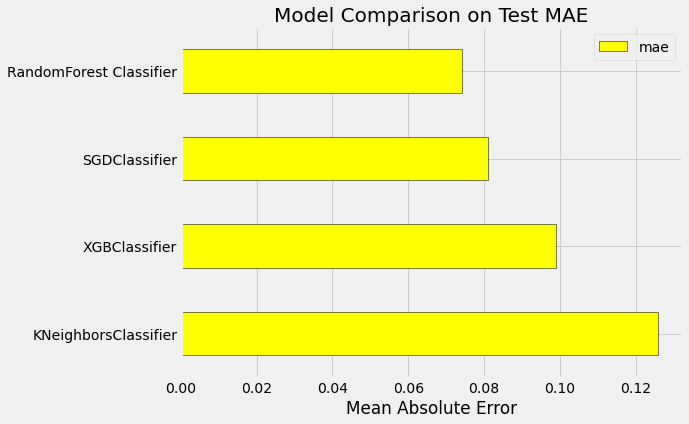

In [51]:
plt.style.use('fivethirtyeight')
# fig = plt.figure(figsize(8, 6))

# Dataframe para armazenar os resultados
model_comparison = pd.DataFrame({'model': ['RandomForest Classifier', 'XGBClassifier', 
                                           'SGDClassifier', 'KNeighborsClassifier'
                                          ],
                                 'mae': [svc1_mae, svc2_mae, 
                                         svc3_mae, svc4_mae]})

# Horizontal bar chart of test mae
model_comparison.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                           color = 'yellow', edgecolor = 'black')

plt.ylabel('')
plt.yticks(size = 14)
plt.xlabel('Mean Absolute Error')
plt.xticks(size = 14)
plt.title('Model Comparison on Test MAE', size = 20)
plt.savefig('Model_Comparison on Test MAE.png')

## Nuvem de etiquetas

## Gobal

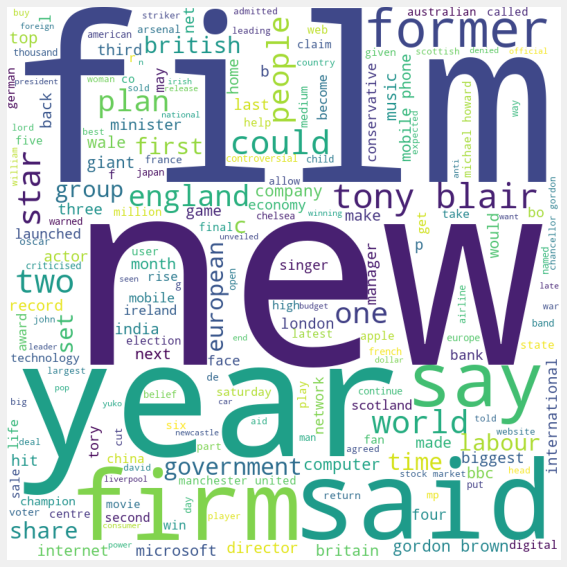

In [32]:
wc = WordCloud(width = 800, height = 800, 
                background_color ='white', 
               stopwords=stopwords,
                min_font_size = 10, random_state=42).generate(df.text3.to_string())

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wc)
plt.tight_layout(pad = 0) 
plt.axis("off")
plt.show()

## por categoria

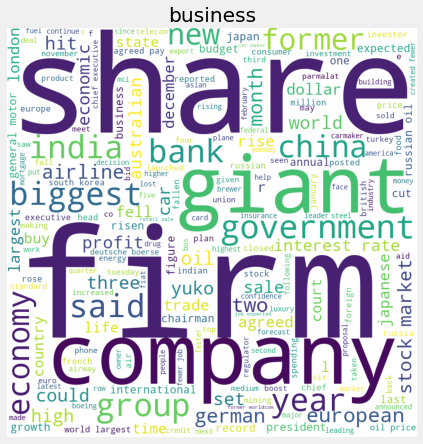

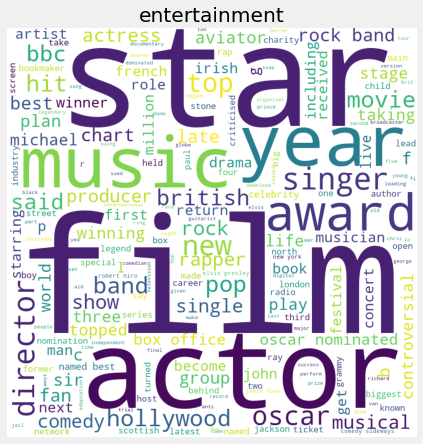

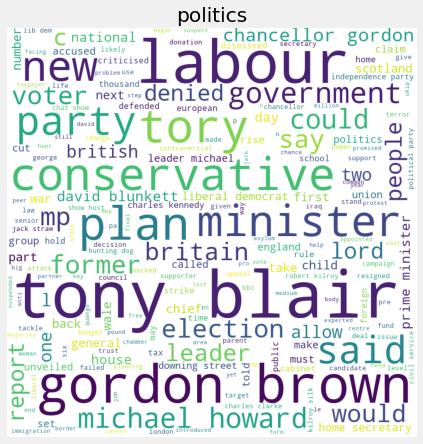

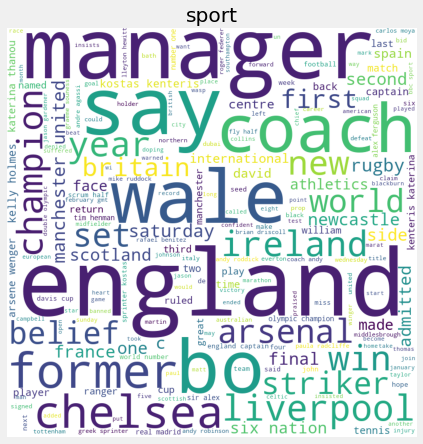

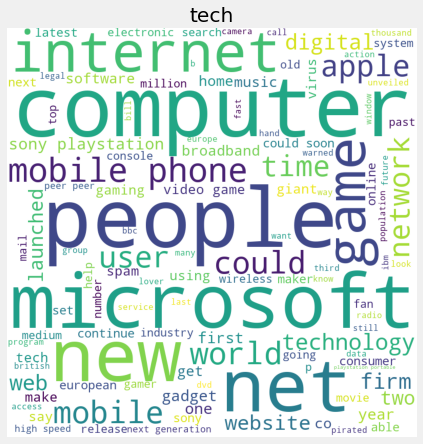

In [33]:
for x in df.category.unique():
    wc = WordCloud(width = 800, height = 800, background_color ='white', stopwords=stopwords,
                   min_font_size = 10, random_state=42)
    wc.generate(df.text3[(df.category == x)].to_string())
    
    plt.imshow(wc)
    plt.tight_layout(pad = 0) 
    plt.title(x)
    plt.axis("off")
    plt.show()

# Clustering

In [34]:
# Definir parâmetros de treinamento
num_topics = 5
chunksize = 1000 # Número de documentos a serem considerados de uma só vez (afeta o consumo de memória)
passes = 30 # Número de passagens por documentos
iterations = 500
eval_every = 1  

# cria um índice para o dicionário de palavras
temp = dictionary[0] 
id2word = dictionary.id2token

model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', random_state=78, \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

In [35]:
# Frequência das principais palavras em cada tópico
def explore_topic(lda_model, topic_number, topn, output=True):
    terms = []
    for term, frequency in lda_model.show_topic(topic_number, topn=topn):
        terms += [term]
        if output:
            print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))   
    return terms

topic_summaries = []

print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(num_topics):
    print('Topic '+str(i)+'\n')
    tmp = explore_topic(model,topic_number=i, topn=10, output=True)
    topic_summaries += [tmp[:5]]
    print('\n')

term                 frequency

Topic 0

mobile               0.012
phone                0.011
technology           0.011
mobile_phone         0.010
music                0.009
service              0.009
digital              0.008
video                0.006
device               0.006
high_definition      0.006


Topic 1

prime_minister       0.007
party                0.007
labour               0.006
election             0.006
minister             0.006
blair                0.005
told_bbc             0.004
law                  0.004
tony_blair           0.004
public               0.004


Topic 2

game                 0.009
year_old             0.007
film                 0.007
best                 0.006
player               0.005
win                  0.004
play                 0.004
award                0.004
england              0.004
last_year            0.004


Topic 3

game                 0.011
software             0.010
computer             0.010
user                 0.009
site    

In [36]:
# Atribui um rotulo interpretável
top_labels = {0: 'business', 1:'sport', 2:'tech', 3:'entertainment', 4:'politics'}

In [37]:
top_dist =[]
for d in corpus:
    tmp = {i:0 for i in range(num_topics)}
    tmp.update(dict(model[d]))
    vals = list(OrderedDict(tmp).values())
    top_dist += [array(vals)]

def get_doc_topic_dist(model, corpus, kwords=False):
    '''
        Transformação LDA, para cada doc só retorna tópicos com peso diferente de zero Esta função faz uma 
        transformação matricial de docs no espaço de tópicos. 

        model: o modelo LDA 
        corpus: os documentos 
        kwords: se True adiciona e retorna as chaves
    '''
    top_dist =[]
    keys = []

    for d in corpus:
        tmp = {i:0 for i in range(num_topics)}
        tmp.update(dict(model[d]))
        vals = list(OrderedDict(tmp).values())
        top_dist += [array(vals)]
        if kwords:
            keys += [array(vals).argmax()]

    return array(top_dist), keys

top_dist, lda_keys= get_doc_topic_dist(model, corpus, True)

In [38]:
top_ws = []
for n in range(len(dtm)):
    inds = int0(argsort(dtm[n])[::-1][:4])
    tmp = [features[i] for i in inds]
    
    top_ws += [' '.join(tmp)]
    
df['Text_Rep'] = pd.DataFrame(top_ws)
df['clusters'] = pd.DataFrame(lda_keys)
df['clusters'].fillna(10, inplace=True)

cluster_colors = {0: 'blue', 1: 'green', 2: 'yellow', 3: 'red', 4: 'skyblue'}

df['colors'] = df['clusters'].apply(lambda j: cluster_colors[j])

# Atribui rótulos interpretáveis
df['category_lda'] = df['clusters'].replace([0, 1, 2, 3, 4],['business','sport','tech','entertainment','politics'])

## Clusters visualization

In [39]:
from bokeh.plotting import figure, show, output_notebook, save
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource

In [40]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(top_dist)

df['X_tsne'] =X_tsne[:, 0]
df['Y_tsne'] =X_tsne[:, 1]

output_notebook()

source = ColumnDataSource(dict(
    x=df['X_tsne'],
    y=df['Y_tsne'],
    color=df['colors'],
    label=df['clusters'].apply(lambda l: top_labels[l]),
    topic_key= df['clusters'],
    title= df[u'title'],
    content = df['text3'],
    legend_field=df['category_lda']
))

df = df.drop(columns=['colors','Text_Rep','X_tsne','Y_tsne'])

Loading BokehJS ...

In [41]:
title = 'Topics visualization'

plot_lda = figure(plot_width=1000, plot_height=600,
                     title=title, 
                     x_axis_type=None, y_axis_type=None, min_border=1)
plot_lda.scatter(x='x', y='y', legend_field='legend_field',  source=source,
                 color='color', alpha=0.6, size=5.0)

# hover tools
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"content": "Title: @title, KeyWords: @content - Topic: @topic_key "}
plot_lda.legend.location = "top_left"

show(plot_lda)

In [42]:
print(f"Categorias corretas: {len(df[df.category==df.category_lda])}")

Categorias corretas: 65


In [43]:
print(f"Porcentagem de categorias corretas: {round(len(df[df.category==df.category_lda])/len(df)*100,2)}%")

Porcentagem de categorias corretas: 2.92%
